<a href="https://colab.research.google.com/github/pedrogengo/3D_avatar_generator/blob/main/notebooks/Create_Your_own_3D_Avatar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate a 3D Avatar of Yourself

Get a 3D Avatar of Yourself from your images.

Our workflow explores this proposal in the following stages:

- First we upload the image and supply a prompt
- Next we use an IP Adapter to convert the image in a specific style
- Finally we use the pretrained TripoSR model from StabilityAI to generate a 3D object
- We also render video of the 3D object for showcasing.


> ## This sounds interesting, how does the image to 3D workflow work?

"TripoSR is a fast and feed-forward 3D generative model developed in collaboration between Stability AI and Tripo AI."

TripoSR is meant to follow the pipeline of the LRM model (Large Reconstruction Model for Single Image to 3D) very closely.

![img](https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/Screenshot%202024-03-25%20at%2011.52.06%E2%80%AFPM.png)

LRM takes an image and tries to turn it into a 3D model. Here's how it works:

1. **Image Understanding:** LRM first uses a pre-trained image recognition model to understand the objects and details in the image. This model pays attention to both the structure and texture of the object.

2. **Camera Awareness:** LRM also considers the camera angle and position that took the picture. This helps to account for any distortion caused by the camera.

3. **Space Slicing:** LRM imagines the 3D space around the object divided into thin slices along three axes (like chopping a box into slabs). This is called a triplane representation.

4. **Image to Triplane Mapping:** LRM uses the image information and camera awareness to project details onto these slices. It does this by letting the slices "talk" to the image features, like matching puzzle pieces.

5. **Fine-tuning the Slices:** LRM refines the slices further by considering the relationships between the details within each slice and across different slices.

6. **3D Prediction:** Finally, LRM uses the information in the refined slices to predict the color and density of every point in 3D space, essentially creating a volume that represents the 3D model.

LRM can also use additional side views of the same object during training to improve the accuracy of the 3D reconstruction.

## Setup

We first clone the TripoSR repository into our notebooks and set our device type.

Note: Remember to install the requirements file of the TripoSR model.

In [3]:
!git clone https://github.com/ritwikraha/TripoSR.git

fatal: destination path 'TripoSR' already exists and is not an empty directory.


In [2]:
import sys
sys.path.append('/content/TripoSR/tsr')

In [4]:
%cd TripoSR

/content/TripoSR


In [4]:
!pip install -r requirements.txt -q
!pip install -U diffusers accelerate -qq

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.5/688.5 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 114.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import torch
# Adjust device based on CUDA availability
device = "cuda" if torch.cuda.is_available() else "cpu"

## Imports

In [6]:
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from transformers import CLIPVisionModelWithProjection
from diffusers.utils import load_image
import os
import time
from PIL import Image
import numpy as np
from IPython.display import Video
from tsr.system import TSR
from tsr.utils import remove_background, resize_foreground, save_video
import rembg

## Load the Pipelines for Image Preprocessing

We use an Adapter to process the image in a specific style.

An IP-Adapter with only 22M parameters can achieve comparable or even better performance to a fine-tuned image prompt model. IP-Adapter can be generalized not only to other custom models fine-tuned from the same base model, but also to controllable generation using existing controllable tools. Moreover, the image prompt can also work well with the text prompt to accomplish multimodal image generation.


In [13]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
).to(device)



1. Loading the Base Text-to-Image Pipeline:

- We start by loading a pre-trained text-to-image pipeline model called `AutoPipelineForText2Image` from the `stabilityai/stable-diffusion-xl-base-1.0` model repository.


2. Configuring the Schedule:

- We initilaise a new `DDIMScheduler` for controlling different phases of the image generation process.


3. Loading and Setting Up the Image Processing Adapter:

- We load an IP adapter model, from a repository called `h94/IP-Adapter`.
- We specify a subfolder `sdxl_models` where the adapter weights are stored.
- We provide two weight names: `ip-adapter-plus_sdxl_vit-h.safetensors` and `ip-adapter-plus-face_sdxl_vit-h.safetensors`.
- We set a scaling factor of `[0.7, 0.3]` for likely balancing the influence of different adapter components on final images.



In [14]:
pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    image_encoder=image_encoder,
).to(device)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="sdxl_models",
  weight_name=["ip-adapter-plus_sdxl_vit-h.safetensors", "ip-adapter-plus-face_sdxl_vit-h.safetensors"]
)
pipeline.set_ip_adapter_scale([0.7, 0.3])
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Timer Class for Utility



We define a `Timer` class to track execution times. It stores start times for named timers in a dictionary. The `start` method records the current time for a given timer name. The `end` method retrieves the start time, calculates the elapsed time (adjusted to milliseconds), and prints the name and duration.

We then create a `Timer` object named `timer` for use in our program.


In [21]:
# Define Timer class
class Timer:
    def __init__(self):
        self.items = {}
        self.time_scale = 1000.0  # ms
        self.time_unit = "ms"

    def start(self, name: str) -> None:
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.items[name] = time.time()

    def end(self, name: str) -> float:
        if name not in self.items:
            return
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start_time = self.items.pop(name)
        delta = time.time() - start_time
        t = delta * self.time_scale
        print(f"{name} finished in {t:.2f}{self.time_unit}.")

timer = Timer()

## Upload your data and Generate Avatar Image

### Upload your picture

In [8]:
from google.colab import files

uploaded = files.upload()

Saving sample.png to sample (1).png


In [9]:
# @title Enter a prompt { run: "auto", vertical-output: true, form-width: "10000px", display-mode: "form" }
prompt = "a 3D version of this person" # @param {type:"string"}


### Upload the style images to guide the generation

Here, we are using some images hosted on HF that have the funko pop style. If you want, you can change it to use any style you want.

In [10]:
face_image = Image.open(list(uploaded.keys())[0])
style_folder = "https://huggingface.co/datasets/pedrogengo/funkopop_images/resolve/main"
style_images = [load_image(f"{style_folder}/funko{i}.jpeg").resize((1024, 1024)) for i in range(1, 5)]

### Generate images using the pipeline

Supply the prompt and the style and object image. We can also specifiy the `num_inference_steps` to `50`, we can also set that as we need, a more number of steps will be useful in diluting the `strength` parameter.

In [15]:
generator = torch.Generator(device=device).manual_seed(42)

image = pipeline(
    prompt=prompt,
    ip_adapter_image=[style_images, face_image],
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    num_inference_steps=50, num_images_per_prompt=1,
    generator=generator,
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

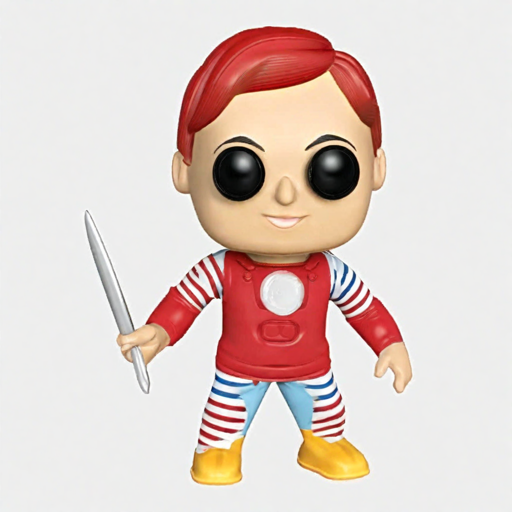

In [16]:
image.resize((512, 512))

In [17]:
image.resize((512, 512)).save("examples/avatar.jpg")

## The TripoSR model for 3D Avatar

In [18]:
# Parameters for running the TripoSR
image_paths = "/content/TripoSR/examples/avatar.jpg"
device = "cuda:0"
pretrained_model_name_or_path = "stabilityai/TripoSR"
chunk_size = 8192
no_remove_bg = True
foreground_ratio = 0.85
output_dir = "output/"
model_save_format = "obj"
render = True

In [19]:
output_dir = output_dir.strip()
os.makedirs(output_dir, exist_ok=True)

### Generate Images for the 3D model

**Initializing:**
- Load the TSR model from disk and set its rendering chunk size.
- Place the model on the appropriate device (CPU or GPU) for computations.

**Processing Images:**
- Create a list to store processed images.
- Initiate a background removal session using rembg.
- For each image:
    - Remove the background.
    - Resize the foreground to a specified ratio.
    - If the image has an alpha channel:
        - Normalize pixel values and handle alpha blending for smooth compositing.
    - Save the processed image as "input.png" in a unique output directory.
    - Append the image to the list.




In [22]:
# Initialize model
timer.start("Initializing model")
model = TSR.from_pretrained(
    pretrained_model_name_or_path,
    config_name="config.yaml",
    weight_name="model.ckpt",
)
model.renderer.set_chunk_size(chunk_size)
model.to(device)
timer.end("Initializing model")

# Process images
timer.start("Processing images")
images = []


rembg_session = rembg.new_session()

image = remove_background(image, rembg_session)
image = resize_foreground(image, foreground_ratio)

if image.mode == "RGBA":
  image = np.array(image).astype(np.float32) / 255.0
  image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
  image = Image.fromarray((image * 255.0).astype(np.uint8))

image_dir = os.path.join(output_dir, str(0))
os.makedirs(image_dir, exist_ok=True)
image.save(os.path.join(image_dir, "input.png"))
images.append(image)
timer.end("Processing images")

config.yaml:   0%|          | 0.00/987 [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

Initializing model finished in 14044.21ms.


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 151GB/s]


Processing images finished in 5124.36ms.


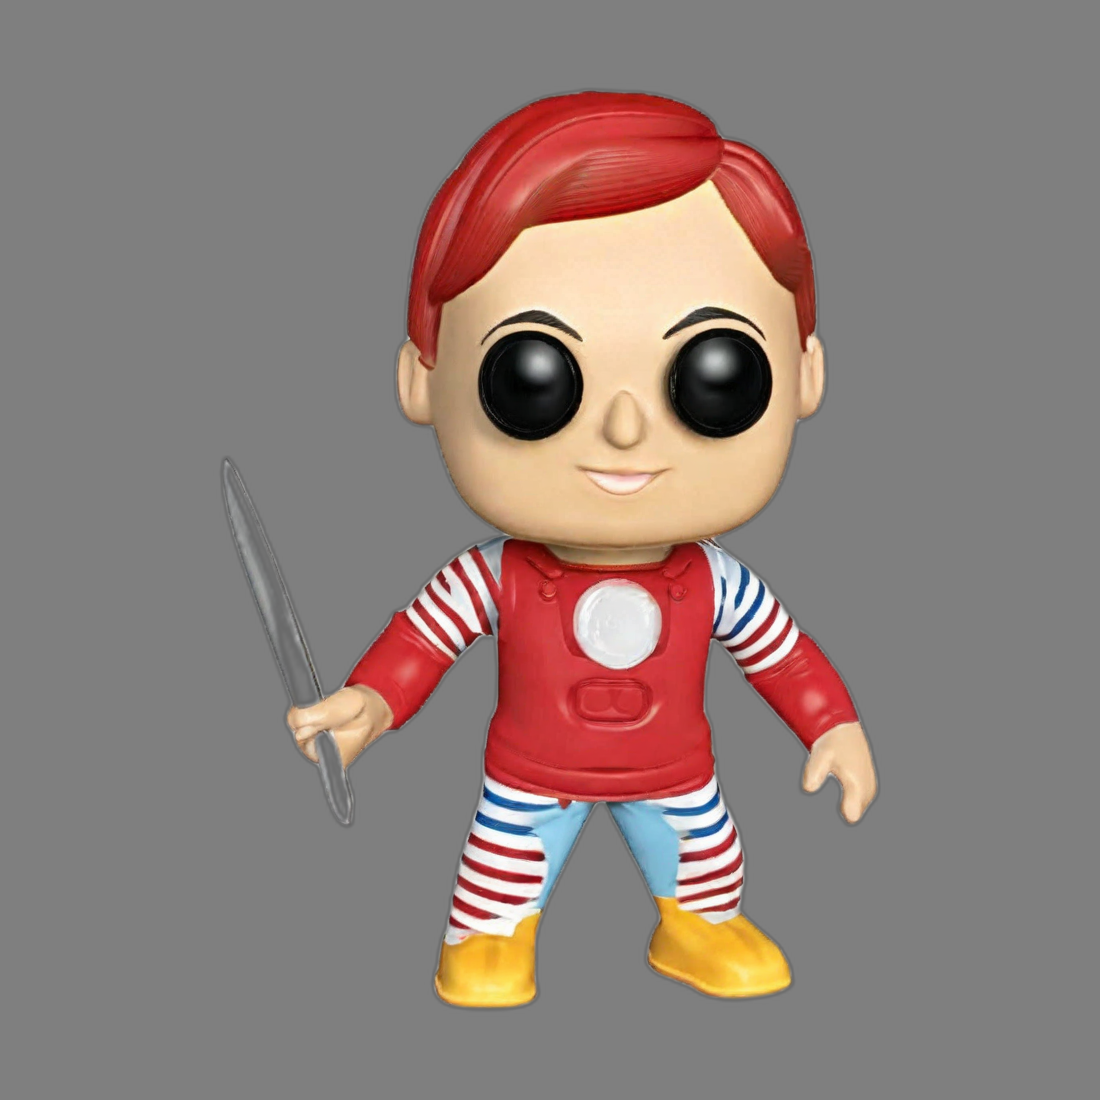

In [23]:
# Visualise the image
image

### Render Video from Images


**Processing Each Image:**

- **Loop through each image:**
    - Print a progress message.
    - **Run the model:**
        - Disable gradients for efficiency.
        - Pass the image through the model to generate scene codes.
    - **Conditionally render (if specified):**
        - Generate 30 rendered views from the scene codes.
        - Save each view as a PNG image and a video of the views as an MP4 file.
    - **Extract and export mesh:**
        - Extract the 3D mesh from the scene codes.
        - Save the mesh in the specified format.



In [24]:
# Process each image
for i, image in enumerate(images):
    print(f"Running image {i + 1}/{len(images)} ...")

    # Run model
    timer.start("Running model")
    with torch.no_grad():
        scene_codes = model([image], device=device)
    timer.end("Running model")

    # Rendering
    if render:
        timer.start("Rendering")
        render_images = model.render(scene_codes, n_views=30, return_type="pil")
        for ri, render_image in enumerate(render_images[0]):
            render_image.save(os.path.join(output_dir, str(i), f"render_{ri:03d}.png"))
        save_video(
            render_images[0], os.path.join(output_dir, str(i), "render.mp4"), fps=30
        )
        timer.end("Rendering")

    # Export mesh
    timer.start("Exporting mesh")
    meshes = model.extract_mesh(scene_codes)
    mesh_file = os.path.join(output_dir, str(i), f"mesh.{model_save_format}")
    meshes[0].export(mesh_file)
    timer.end("Exporting mesh")

print("Processing complete.")

Running image 1/1 ...
Running model finished in 375.28ms.


/content/TripoSR/tsr/utils.py:376: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:63.)
  right = F.normalize(torch.cross(lookat, up), dim=-1)


Rendering finished in 28717.33ms.
Exporting mesh finished in 2901.91ms.
Processing complete.


## Output Video

In [25]:
# Display the video
Video('output/0/render.mp4', embed=True)